<a href="https://colab.research.google.com/github/liamhall64/Habitable-Exomoons/blob/main/Probability_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const

!pip install pytransit celerite emcee corner
from pytransit import QuadraticModel
# from pytransit import UniformModel
from scipy.optimize import minimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.0/308.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.1/698.1 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


# Functions

In [612]:
# ROCHE LIMIT AND HILL SPHERE CALUCLATIONS
def hillsphere(Mp, Ms, a):
  hill = a*((Mp/(3*Ms)))**(1/3)
  return hill

def roche_lim(Rp, P_dens, M_dens):
  roche = Rp * (2*(dens_p/dens_m))**(1/3)
  return roche

def CHZ(L_star, S_eff):
  habitable_zone = np.sqrt(L_star/(const.L_sun*S_eff))*u.AU
  return habitable_zone

def per(tot_mass, distance):
  period = ((4*np.pi**2)/(const.G*tot_mass)*distance**3)**0.5 # KEPLER'S THIRD LAW
  return period.to(u.day)

def barycentre(Mp, Mm, dpm, moon_period):
  dp = dpm/(1+(Mp/Mm)) # DIST BARYCENTRE TO PLANET
  dm = dpm/(1+(Mm/Mp)) # DIST BARYCENTRE TO MOON
  #print(f'Planet-barycentre distance = {dp:.3f}\nMoon-barycentre distance = {dm:.3f}')
  return dp, dm

# Variables

In [4533]:
abc = 3 # VALUE OF DISTANCE BETWEEN ROCHE AND HILL SPHERE
xyz = 10 # DISTANCE TO SYSTEM IN PC

# Parameters

In [4534]:
# STELLAR PARAMETERS
dist_to_sys = (xyz*u.parsec).to(u.m)
stellar_mass = 0.157*const.M_sun
Rs = 0.2110*const.R_sun
temp = 3026*u.K
stellar_lum = 4*np.pi*Rs**2*const.sigma_sb*temp**4

separation = CHZ(stellar_lum, 1).to(u.m)

# PLANET PARAMETERS
plan_mass = 1.2*const.M_jup # SANTERNE ET AL 2016
Rp = 1.0038*const.R_jup  # WEISS ET AL 2024
dens_p = 911.8*u.kg/u.m**3 # WEISS ET AL 2024
P = per((stellar_mass + plan_mass), separation)

# MOON PARAMETERS
moon_mass = 1*const.M_earth # ASSUMING EARTH MASS FOR MOON
dens_m = 5513*u.kg/u.m**3

roche, hill = roche_lim(Rp, dens_p, dens_m), hillsphere(plan_mass, stellar_mass, separation)

distance = np.linspace(roche, hill, 10)
# SIMULATED DISTANCE
dpm = distance[abc-1]
#dpm = 384400000*u.m

print(f'Roche = {roche.to(u.km):.3f}\nHill = {hill.to(u.au):.6f}\nEarth\'s Roche limit and Hill sphere from the literature is given by 9497 km and 0.01 AU respectively.')
print(f'Semi-major axis for the planet = {separation.to(u.AU):.3f}')

Roche = 49630.864 km
Hill = 0.007799 AU
Earth's Roche limit and Hill sphere from the literature is given by 9497 km and 0.01 AU respectively.
Semi-major axis for the planet = 0.058 AU


In [4535]:
earth_years = 5*365.25*u.day
orbits = (earth_years / P)

In [4536]:
period = per(plan_mass + moon_mass, dpm)

print(f'Test for Earth-Moon Period = {per(const.M_earth+0.0123*const.M_earth, 384.4e6*u.m):.2f}') # TEST ON EARTH-MOON
print(f'Planet-moon period = {period:.2f}') # PLANET-MOON CALC ASSUMING MOON HALFWAY BETWEEN ROCHE AND HILL

Test for Earth-Moon Period = 27.28 d
Planet-moon period = 0.96 d


In [4537]:
dp, dm = barycentre(plan_mass, moon_mass, dpm, period)

# TTV calculations

In [4538]:
N_trials = 100 # NUMBER OF ANGLES
N_obs = 50 # NUMBER OF OBSERVATIONS/TRANSITS (SHOULD BE WITHIN 5 YEARS AT LEAST)

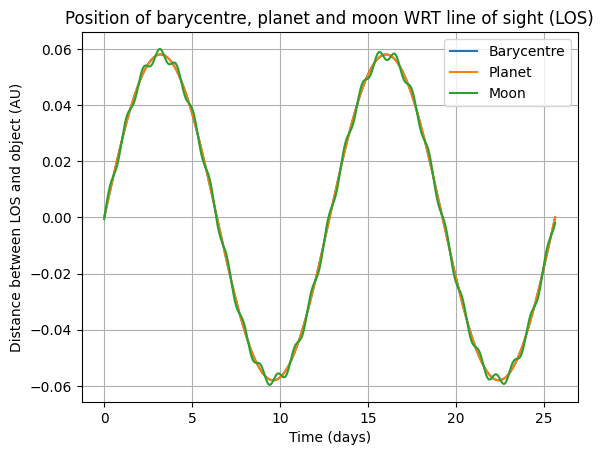

Done


In [4539]:
t = np.linspace(0, 2*P, 1000)

# BARYCENTRE
ab = separation # SEPARATION
Pb = P.to(u.s)  # PERIOD
wb = (2*np.pi/Pb) *u.rad # ANGULAR FREQ
alphab = wb*t
xb = ab*np.sin(alphab)

angle = []
def position(N_trials):
  for i in range(N_trials):
    angle.append(np.random.uniform(0, 2*np.pi)*u.rad)
    #print(f"Start angle #{i+1} = {angle[i]:.3f}") # IF WE WANT TO PRINT THE LIST OF ALL STARTING ANGLES OF 'N' REALISATIONS

    # PLANET
    wp = 2*np.pi/period *u.rad
    alphap = wp*t + angle[i]
    xp = dp * np.sin(alphap) + xb

    # MOON
    wm = 2*np.pi/period *u.rad
    alpham = wm*t + np.pi*u.rad + angle[i]
    xm = dm*np.sin(alpham) + xb
  return angle, xb, xp, xm, wb, wp, wm, ab, alphap, alpham


angle, xb, xp, xm, wb, wp, wm, ab, alphap, alpham = position(N_trials)

plt.plot(t, xb.to(u.AU), label = 'Barycentre')
plt.plot(t, xp.to(u.AU), label = 'Planet')
plt.plot(t, xm.to(u.AU), label = 'Moon')
plt.title('Position of barycentre, planet and moon WRT line of sight (LOS)')
plt.xlabel('Time (days)')
plt.ylabel('Distance between LOS and object (AU)')
plt.legend()
plt.grid()
#plt.xlim(9,10)
#plt.ylim(-0.062,-0.055)
plt.show()
print('Done')

In [4540]:
t = np.arange(0,N_obs*P.value,P.value)*P.unit # TIME

# BARYCENTRE
ab = separation # SEPARATION
Pb = P.to(u.s)  # PERIOD
wb = (2*np.pi/Pb) *u.rad # ANGULAR FREQ
alphab = wb*t
xb = separation*np.sin(alphab)

ttvp = []
det = 0

for i in range(N_trials):
  angle = np.random.uniform(0, 2*np.pi)*u.rad

  # PLANET
  wp = 2*np.pi/period *u.rad
  alphap = wp*t + angle
  xp = dp * np.sin(alphap) + xb
  diffp = xb - xp

  vb = (2*np.pi*ab)/P.to(u.s) # BARYCENTRE VELOCITY
  #print(f'Velocity of system around star = {vb:.3f}')
  ttvp.append(diffp/vb)
  if N_trials <=10:
    print(ttvp[i])
else:
  print('Too many to print!')
ttvp = ttvp[i].to(u.day)

Too many to print!


# Light curve

Done


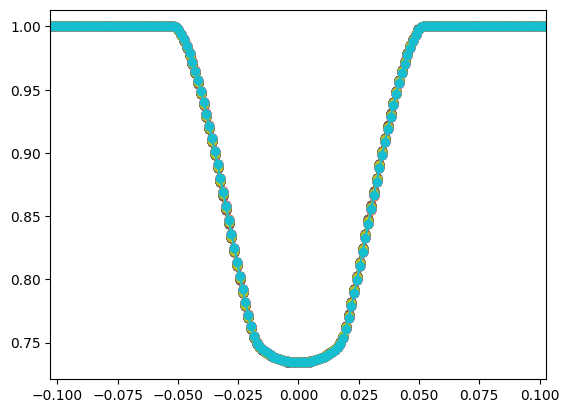

In [4541]:
# SWAPPED THE t0 FOR ttvp FOR THE TIME OF INFERIOR CONJUNCTION IN DAYS TO RUN IN A LOOP TO GET MULTIPLE LIGHT CURVES

T14 = (2*Rs+2*Rp)/vb
T14 = T14.to(u.day)

rp_rs = Rp/Rs        #planet radius / stellar radius ratio
ars =  separation/Rs              #semi-major axis / stellar radius ratio
inc =  (90*u.deg).to(u.rad).value    #orbital inclination (in radians)
ecc = 0.                             #eccentricity
w = (90*u.deg).to(u.rad).value       #longitude of periastron (in radians)
gamma = [0.231, 0.226]                 #limb darkening coefficients [u1, u2]

texp = 100*u.s.to(u.day)             # the exposure time : we convert seconds to days
t = np.arange(-0.5, 0.5, texp)       # new timegrid #note we use np.arange rather than np.linspace (DAYS) MANDEL AND........
tm = QuadraticModel()                # a model that uses two limb-darkening coefficients
tm.set_data(t)

lc_Earth = []
for j in range(len(ttvp)):
  # ttvp[j] is a scalar Quantity, so we directly use it as t0_val
  t0_val = ttvp[j].value
  lc_Earth.append(tm.evaluate(k=rp_rs, ldc=gamma, t0=t0_val, p=np.float64(P), a=ars, i=inc, e=ecc, w=w))
  plt.plot(t, lc_Earth[j], '-o') # Plot the last added light curve
  plt.xlim(-T14.value,T14.value)
print('Done')

In [4542]:
def planck(wl, T):
  a = np.float64(1.191042768e8)*u.um**5 *u.W/ u.m**2 /u.sr/u.um
  b = np.float64(14387.7516)*1*u.um * 1*u.K
  try:
    x = b/(wl*T)
    bb = a/wl**5 / (np.exp(x) - 1.0)
  except ArithmeticError:
    bb = np.zeros(np.size(wl))
  return bb

wl = np.linspace(0.6, 5.3, 1000)*u.um                    # JWST NIRSPEC PRISM WAVELENGTH RANGE 0.6-5.3 (OR HUBBLE 1.1-1.7)
wl_full = np.linspace(0,6, 1000)*u.um
BB_flux = np.pi*u.sr*planck(wl,temp)                      # FLUX DENSITY - W/M^2/MICRONS
BB_flux_full = np.pi*u.sr*planck(wl_full,temp)

####

R_s = Rs # host star radius in Rsun (code converts this to m)
d = dist_to_sys

Flux = BB_flux*(R_s/d)**2

D = 6.5*u.m; Atel = np.pi*(D/2)**2 # APERTURE OF SPECIFIC TELESCOPE
trans = 0.5; QE = 0.8 # QUANTUM EFFICIENCY
Power_per_micron = Flux*Atel*trans*QE # WATTS / MICRON
Power = Power_per_micron*np.gradient(wl) # WATTS

Photons_per_second = Power/(const.h*const.c/wl.to(u.m)) # CONVERT WATTS TO PHOTONS
Photons_per_second = np.sum(Photons_per_second).value*1/u.s # TOTAL ELECTRONS PER SECOND

exposure_time = 100*u.s # GENRALISED EXPOSURE
Electrons = (Photons_per_second*exposure_time).value
std = Electrons**0.5

Noise = Electrons**0.5 # ASSUMING A NOISE LIMITED INSTRUMENT
Noise = np.random.normal(0, Noise, len(lc_Earth[0]))

'''
for i in range(len(lc_Earth)):
  lc = lc_Earth[0]*Electrons
  lc = lc + Noise
  plt.plot(t, lc, '-o', label = f'transit {i+1}')
  plt.grid()
  plt.title('Noise light curves for each ')
  plt.ylabel('Relative signal')
  plt.xlabel('Time (days)')
  plt.xlim(-T14.value,T14.value)
  if N_obs <=10:
    plt.legend()
'''

"\nfor i in range(len(lc_Earth)):\n  lc = lc_Earth[0]*Electrons\n  lc = lc + Noise\n  plt.plot(t, lc, '-o', label = f'transit {i+1}')\n  plt.grid()\n  plt.title('Noise light curves for each ')\n  plt.ylabel('Relative signal')\n  plt.xlabel('Time (days)')\n  plt.xlim(-T14.value,T14.value)\n  if N_obs <=10:\n    plt.legend()\n"

In [4543]:
def chi_squared(X, lc, Noise):
    rp_rs = X[0]
    S = X[1]
    t_0 = X[2]
    model =tm.evaluate(k=rp_rs, ldc=gamma, t0=t_0, p=np.float64(P), a=ars, i=inc, e=ecc, w=w) *S
    return np.sum(((model-lc))**2/Noise**2)

t0 = ttvp
data_lc = lc_Earth[0]
S= Electrons

fit_init = [((lc_Earth[0].max()-lc_Earth[0].min())/ lc_Earth[0].max())**0.5, np.mean(lc_Earth[0][0:40]), t0[0].value+np.random.normal(0,0.001)] # these are initial guesses - we'll cheat a bit by putting in the known values but you can try starting with different initial values too
# Access the first element of t0.value to ensure it's a scalar
bounds =((rp_rs*0.99,rp_rs*1.1), (S*0.99,S*1.1), (np.min(ttvp.value),np.max(ttvp.value))) # the bounds over which the algorithm will vary the parameters
# Use std instead of Noise
fit  = minimize(chi_squared, fit_init, args=(data_lc, std), method='Nelder-Mead', jac=None, hess=None, hessp=None, bounds=bounds, constraints=(), tol=None, callback=None, options=None)
final_fit = [fit['x'][0], fit['x'][1], fit['x'][2]]
if N_obs <= 10:
  print ('Fitted Rp/Rs', final_fit[0], 'Actual Rp/Rs', rp_rs)
  print ('Fitted S', final_fit[1], 'Actual S', S)
  print ('Fitted t0', final_fit[2], 'Actual t0', t0)

model_fit = tm.evaluate(k=fit['x'][0], ldc=gamma, t0=fit['x'][2], p=np.float64(P), a=ars, i=inc, e=ecc, w=w) *fit['x'][1]
'''
plt.figure('lc')
plt.plot(t,data_lc, 'o')
plt.plot(t,model_fit, '-')
plt.xlim(-T14.value,T14.value)
plt.show();
'''
print('Done')

Done


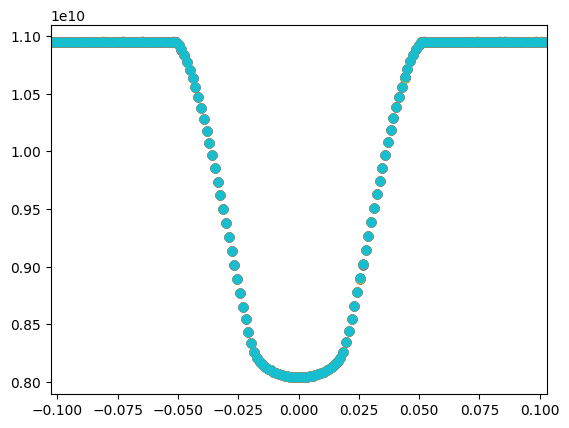

In [4544]:
t0_list = []

for i in range(N_obs):
  Noise = Electrons**0.5 # ASSUMING A NOISE LIMITED INSTRUMENT
  Noise = (np.random.normal(0, Noise, len(lc_Earth[0])))

  lc = lc_Earth[0]*Electrons
  lc = lc + Noise

  if N_obs <=10:
    plt.plot(t, lc, '-o')
    plt.grid()
    plt.title('Noise light curves for each ttv')
    plt.ylabel('Relative signal')
    plt.xlabel('Time (days)')

  t0 = ttvp
  data_lc = lc
  S = Electrons

  fit_init = [((lc.max()-lc.min())/ lc.max())**0.5, np.mean(lc[0:40]), t0[0].value+np.random.normal(0,0.001)] # these are initial guesses - we'll cheat a bit by putting in the known values but you can try starting with different initial values too
  # Access the first element of t0.value to ensure it's a scalar
  bounds =((rp_rs*0.99,rp_rs*1.1), (S*0.99,S*1.1), (-0.01,0.01)) # the bounds over which the algorithm will vary the parameters
  # Use std instead of Noise
  fit  = minimize(chi_squared, fit_init, args=(data_lc, std), method='Nelder-Mead', jac=None, hess=None, hessp=None, bounds=bounds, constraints=(), tol=None, callback=None, options=None)
  final_fit = [fit['x'][0], fit['x'][1], fit['x'][2]]
  #print ('Fitted Rp/Rs', final_fit[0], 'Actual Rp/Rs', rp_rs_Earth)
  #print ('Fitted S', final_fit[1], 'Actual S', S)
  #print ('Fitted t0', final_fit[2], 'Actual t0', t0)

  model_fit = tm.evaluate(k=fit['x'][0], ldc=gamma, t0=fit['x'][2], p=np.float64(P), a=ars, i=inc, e=ecc, w=w) * fit['x'][1]

  #plt.figure('lc')
  plt.plot(t,data_lc, 'o')
  #plt.plot(t,model_fit, '-')

  t0_list.append(final_fit[2])
plt.xlim(-T14.value,T14.value)
plt.show()

# Probability

This calculates the SNR of all light curves and we should expect that for Earth, each transit or observation there should be a detection of a transit timing variation due to size of the Moon and separation.

In [4545]:
t0_list_sec = [t*u.day.to(u.s) for t in t0_list]
stddev = np.std(t0_list_sec)*u.s

det = 0

for i in range(len(ttvp)):
  SNR = np.abs(ttvp[i]/stddev)
  #print(SNR) # IF ANY ARE GREATER THAN 5*SIGMA THEN SUCCESSFUL DETECTION

  if SNR >= 5:
    #if N_obs <=10:
      #print('Detection')
    det = det+1
  #else:
    #print(f'Obs {i+1} = No detection')

prob = 100*det/N_obs
print(f'Probability of detection out of {N_obs} transits = {prob:.1f}%\n')
print(f'std = {stddev}\nDist Planet-moon = {dpm.to(u.km):.2f}')
print(f'Period = {period.to(u.day):2f}')

Probability of detection out of 50 transits = 100.0%

std = 0.014992910608829842 s
Dist Planet-moon = 297864.31 km
Period = 0.957567 d


In [4506]:
distance.to(u.km)

<Quantity [  49630.86392772,  173747.5886561 ,  297864.31338448,
            421981.03811286,  546097.76284125,  670214.48756963,
            794331.21229801,  918447.93702639, 1042564.66175477,
           1166681.38648316] km>